# Линейные модели

## Импорты

In [77]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
random_state = 42

In [6]:
df = pd.read_csv(os.path.join('..', 'data', 'creditcard.csv'))

In [60]:
def plot_precision_recall(y_true, y_scores):
    precisions, recalls, _ = precision_recall_curve(
        y_true, y_scores
    )
    plt.plot(precisions, recalls)

In [61]:
def get_optimum_threshold(y_true, y_pred_proba):
    precisions, recalls, trs = precision_recall_curve(
        y_true, y_pred_proba
    )

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

    return trs[np.argmax(f1_scores)]

In [73]:
def print_metrics(train_true, test_true, train_scores, test_scores):
    trs = get_optimum_threshold(test_true, test_scores)
    print(f'Optimal threshold is - {trs}\n')
    
    train_pred = train_scores >= trs
    test_pred = test_scores >= trs

    print(f'f1 score train - {f1_score(train_true, train_pred)}')
    print(f'f1 score test - {f1_score(test_true, test_pred)}')

    print(f'rocauc score train - {roc_auc_score(train_true, train_scores)}')
    print(f'rocauc score test - {roc_auc_score(test_true, test_scores)}')

    print(f'precision train - {precision_score(train_true, train_pred)}')
    print(f'precision test - {precision_score(test_true, test_pred)}')

    print(f'recall train - {recall_score(train_true, train_pred)}')
    print(f'recall test - {recall_score(test_true, test_pred)}')

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plot_precision_recall(train_true, train_scores)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plot_precision_recall(test_true, test_scores)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Test')
    plt.show()

In [81]:
def draw_score_distr_plot(
    scores_distr, score_type, model_name, in_data_name, out_data_name
):
    sns.set_theme()
    plt.figure(figsize=(12, 8))
    sns.distplot(
        scores_distr[in_data_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=in_data_name,
    )
    sns.distplot(
        scores_distr[out_data_name],
        kde=True,
        norm_hist=True,
        hist=True,
        label=out_data_name,
    )

    plt.title(
        f"{model_name} model Softmax score distribution for {in_data_name} and {out_data_name} datasets"
    )
    plt.xlabel(f"{score_type} score")

    plt.legend()

## Предобработка

In [87]:
df['Amount_log'] = np.log(df['Amount'] + 1e-9)
df.drop(columns=['Amount', 'Time'], axis=1, inplace=True)
data, target = df.drop(columns=['Class'], axis=1), df['Class']
data_train, data_test, target_train, target_test = train_test_split(
    data,
    target,
    test_size=.2,
    stratify=target,
    random_state=random_state
)
data_norm = df[df['Class'] == 0].drop(columns='Class').values
data_anom = df[df['Class'] == 1].drop(columns='Class').values

StratifiedKFold для грид сёрча

In [11]:
skf = StratifiedKFold(5, shuffle=True, random_state=random_state)

## Бейзлайн

Будем предсказывать случайно. Во время EDA мы обнаружили, что только 0.1 процент данных - аномальные. заполним массив нулями и случайно инициализируем $5\%$ аномальных данных - это и будет наш бейзлайн

In [63]:
train_pred = np.zeros_like(target_train)
test_pred = np.zeros_like(target_test)

train_pred[:int(train_pred.shape[0] * .05)] = 1
test_pred[:int(test_pred.shape[0] * .05)] = 1

np.random.seed(random_state)

np.random.shuffle(train_pred)
np.random.shuffle(test_pred)

In [64]:
print(f'f1 score train - {f1_score(target_train, train_pred)}')
print(f'f1 score test - {f1_score(target_test, test_pred)}')

f1 score train - 0.0020363142711691835
f1 score test - 0.0020366598778004067


Результат получился крайне плохим

## Логистическая регрессия

Optimal threshold is - 0.1937166423428027

f1 score train - 0.7941176470588234
f1 score test - 0.7537688442211056
rocauc score train - 0.9809712347928701
rocauc score test - 0.9560971828236077
precision train - 0.8389830508474576
precision test - 0.7425742574257426
recall train - 0.7538071065989848
recall score test - 0.7653061224489796


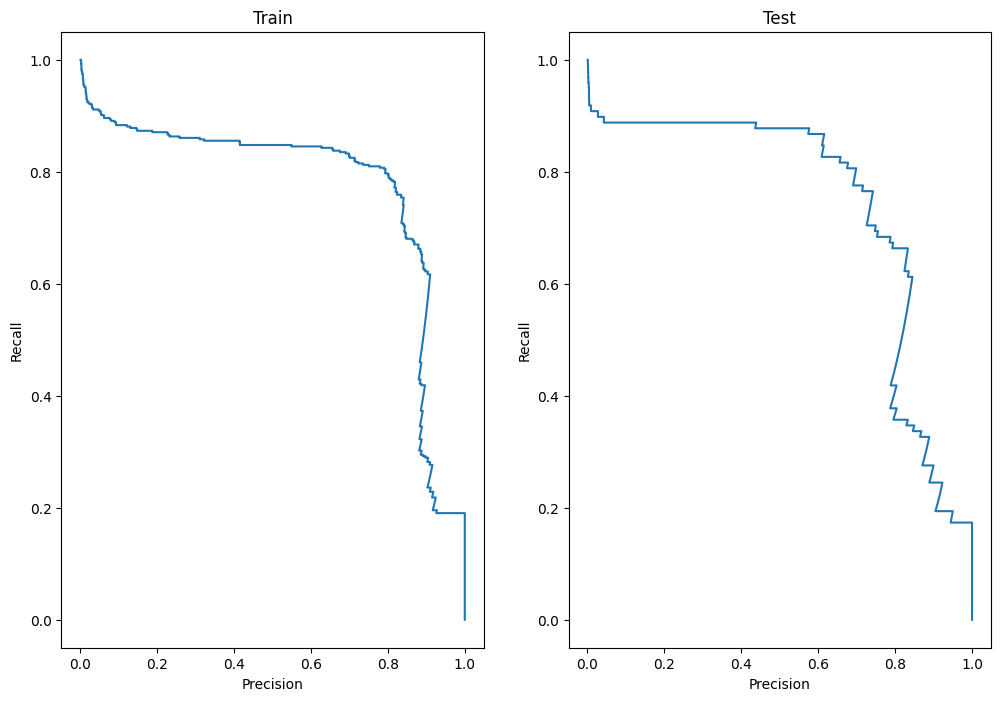

In [67]:
lg_base = LogisticRegression(random_state=random_state)
lg_base.fit(data_train, target_train)

train_scores = lg_base.predict_proba(data_train)[:, 1]
test_scores = lg_base.predict_proba(data_test)[:, 1]

print_metrics(target_train, target_test, train_scores, test_scores)

In [88]:
lg = LogisticRegression(random_state=random_state)

params = {
    'C': np.linspace(0.1, 1, 15),
    'warm_start': (True, False)
}

skf.get_n_splits(data_train, target_train)

gs = GridSearchCV(lg, params, scoring='f1', cv=skf, n_jobs=-1, verbose=5)

gs.fit(data_train, target_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [89]:
gs.best_params_, gs.best_score_

({'C': 0.6142857142857143, 'warm_start': True}, 0.742575745980728)

In [93]:
lg = LogisticRegression(**gs.best_params_, random_state=random_state)
lg.fit(data_train, target_train)

train_scores = lg.predict_proba(data_train)[:, 1]
test_scores = lg.predict_proba(data_test)[:, 1]

norm_scores = lg.predict_proba(data_norm)[:, 1]
anom_scores = lg.predict_proba(data_anom)[:, 1]

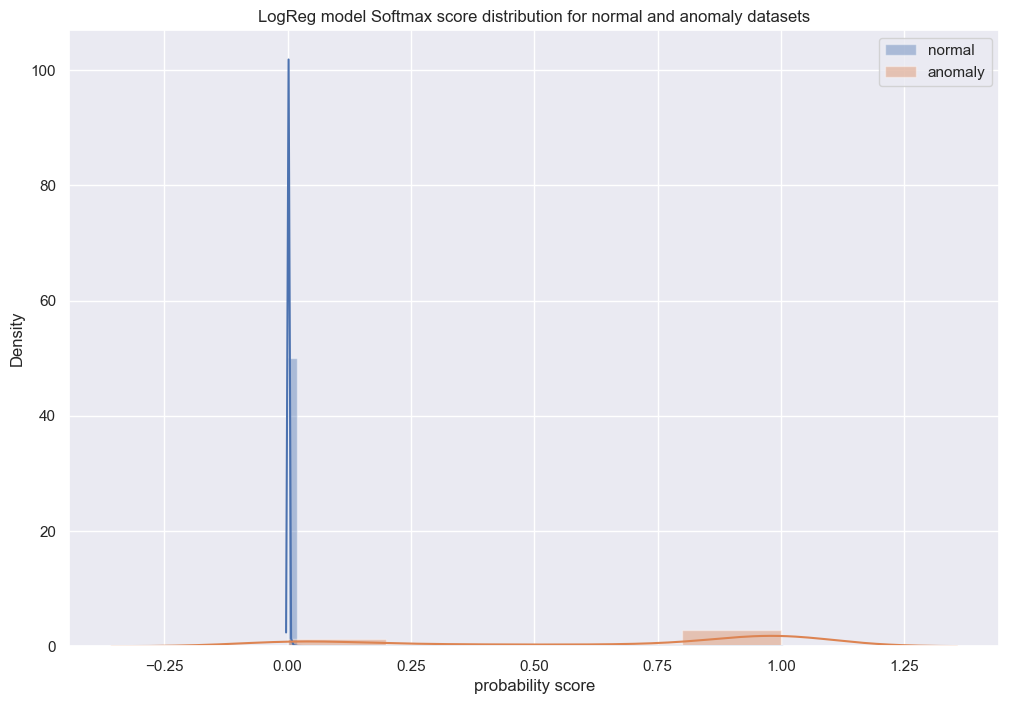

In [94]:
scores_distr = {
    "normal": norm_scores,
    "anomaly": anom_scores,
}

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="probability",
    model_name="LogReg",
    in_data_name="normal",
    out_data_name="anomaly",
)

Optimal threshold is - 0.19765449394737028

f1 score train - 0.7951807228915662
f1 score test - 0.7537688442211056
rocauc score train - 0.9811273346831415
rocauc score test - 0.956478507976066
precision train - 0.8413597733711048
precision test - 0.7425742574257426
recall train - 0.7538071065989848
recall test - 0.7653061224489796


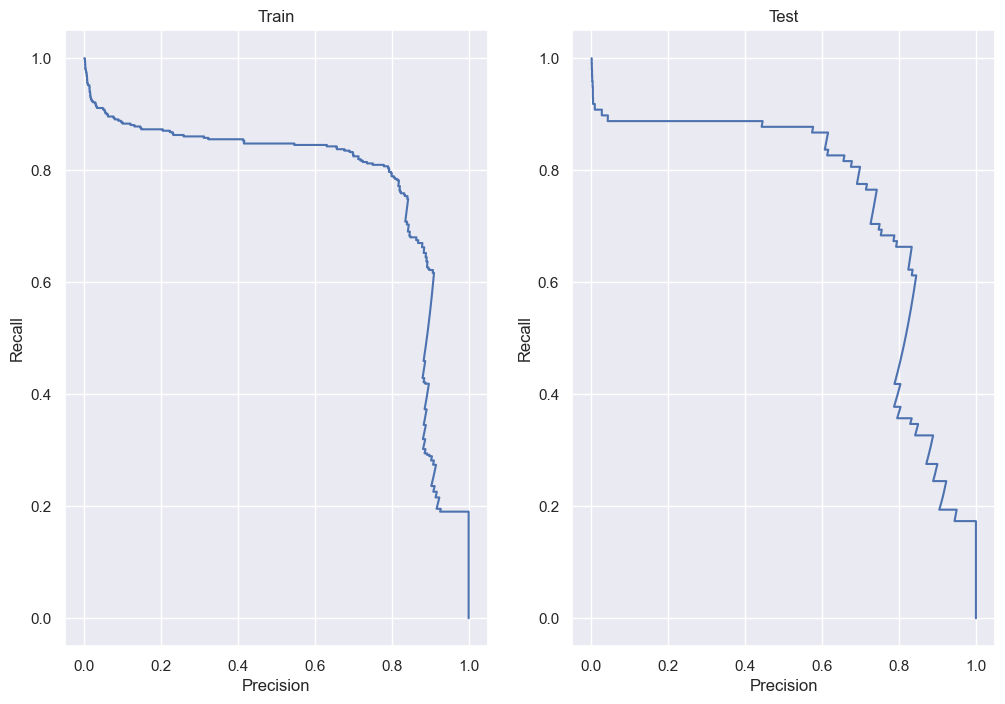

In [95]:
print_metrics(target_train, target_test, train_scores, test_scores)

Можно наблюдать, что обыкновенная линейная регрессия дала отличный результат для определения аномальных данных. Посмотрим, сможем ли мы ещё улучшить метрику

## Over-sampling

In [96]:
data_train_resampled, target_train_resampled = SMOTE(
    random_state=random_state
).fit_resample(data_train, target_train)

lg = LogisticRegression(**gs.best_params_, random_state=random_state)
lg.fit(data_train_resampled, target_train_resampled)

train_scores = lg.predict_proba(data_train)[:, 1]
test_scores = lg.predict_proba(data_test)[:, 1]

norm_scores = lg.predict_proba(data_norm)[:, 1]
anom_scores = lg.predict_proba(data_anom)[:, 1]

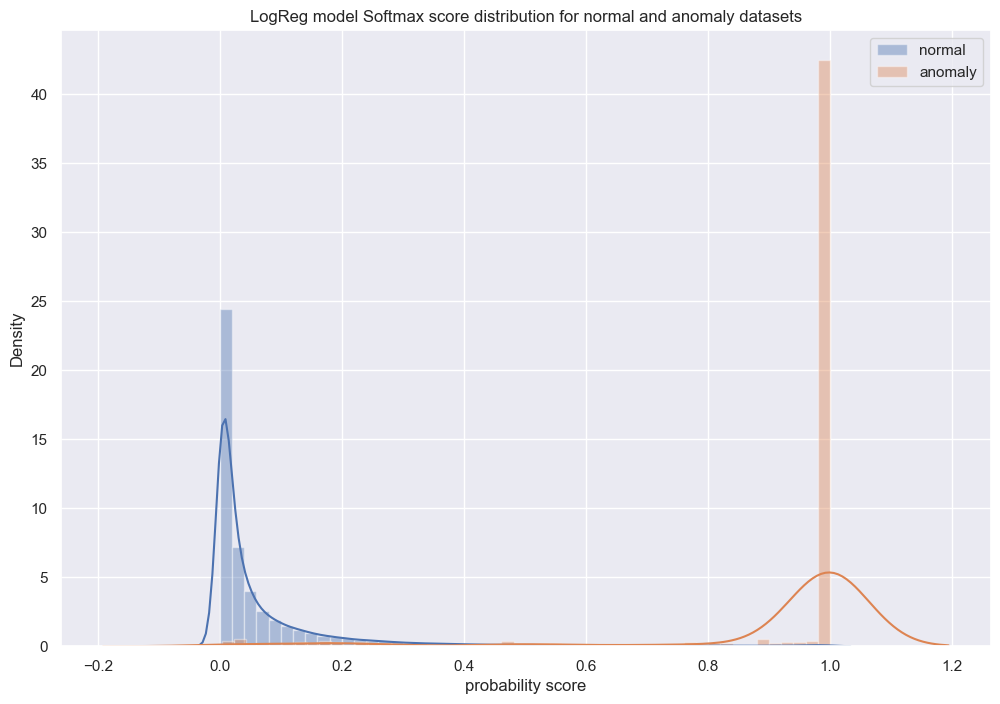

In [97]:
scores_distr = {
    "normal": norm_scores,
    "anomaly": anom_scores,
}

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="probability",
    model_name="LogReg",
    in_data_name="normal",
    out_data_name="anomaly",
)

Optimal threshold is - 0.9999999973801859

f1 score train - 0.8071625344352616
f1 score test - 0.8272251308900525
rocauc score train - 0.9879350150432356
rocauc score test - 0.9697139002618493
precision train - 0.8825301204819277
precision test - 0.8494623655913979
recall train - 0.7436548223350253
recall test - 0.8061224489795918


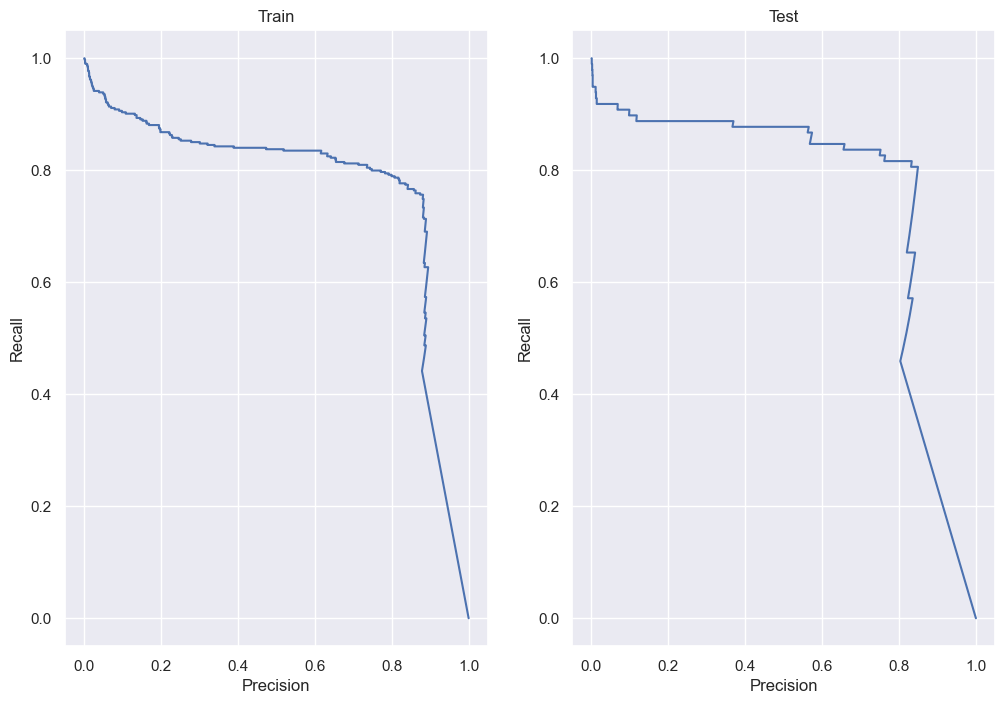

In [98]:
print_metrics(target_train, target_test, train_scores, test_scores)

In [99]:
data_train_resampled, target_train_resampled = ADASYN(
    random_state=random_state
).fit_resample(data_train, target_train)

lg = LogisticRegression(**gs.best_params_, random_state=random_state)
lg.fit(data_train_resampled, target_train_resampled)

train_scores = lg.predict_proba(data_train)[:, 1]
test_scores = lg.predict_proba(data_test)[:, 1]

norm_scores = lg.predict_proba(data_norm)[:, 1]
anom_scores = lg.predict_proba(data_anom)[:, 1]

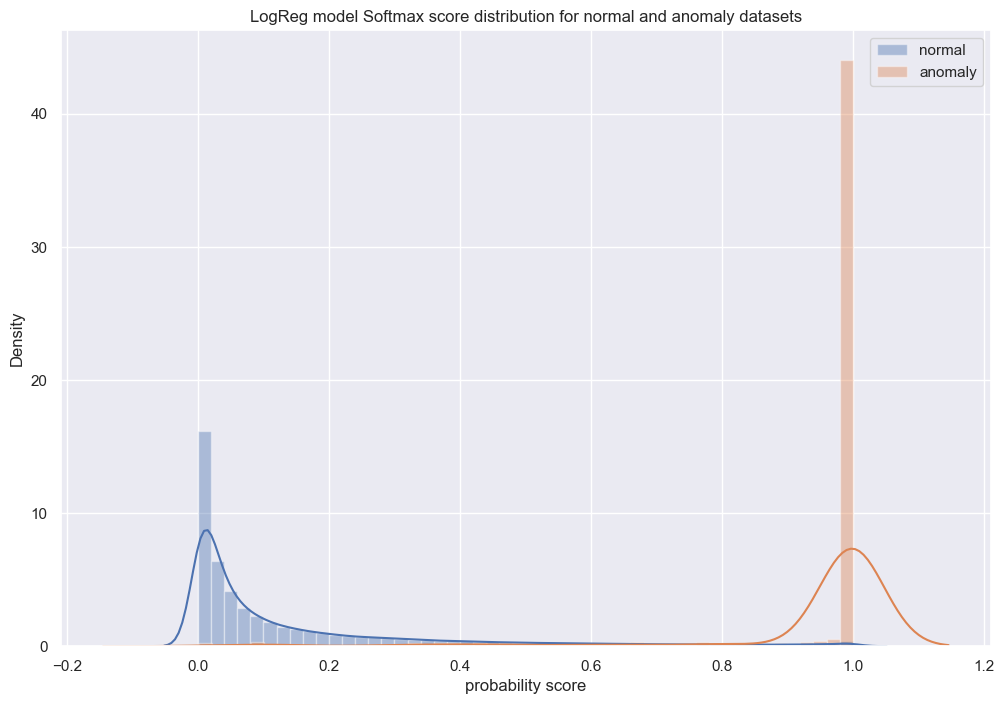

In [100]:
scores_distr = {
    "normal": norm_scores,
    "anomaly": anom_scores,
}

draw_score_distr_plot(
    scores_distr=scores_distr,
    score_type="probability",
    model_name="LogReg",
    in_data_name="normal",
    out_data_name="anomaly",
)

Optimal threshold is - 0.9999999999999851

f1 score train - 0.7934336525307798
f1 score test - 0.8041237113402061
rocauc score train - 0.9890906217832783
rocauc score test - 0.9721069174715469
precision train - 0.8605341246290801
precision test - 0.8125
recall train - 0.7360406091370558
recall test - 0.7959183673469388


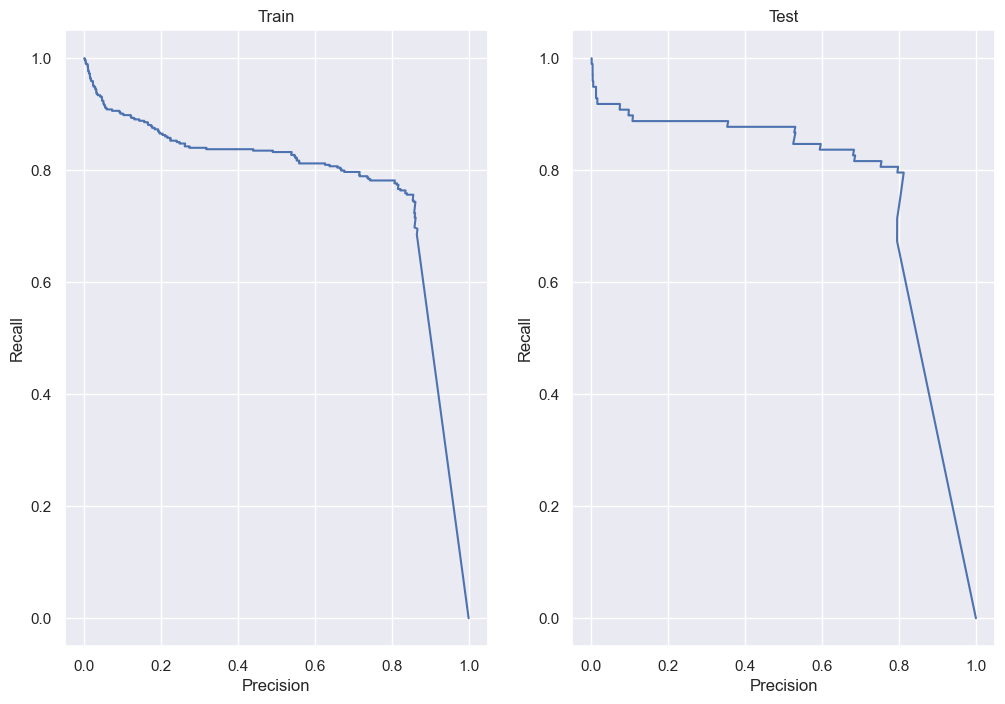

In [101]:
print_metrics(target_train, target_test, train_scores, test_scores)

Как и следовало ожидать, техника over-sampling'a не помогла - аномальных данных слишком мало и алгоритм переобучается на самплированных таргетах. Нет смысла пробовать under-sampling по тем же соображениям - данных будет слишком мало

## Elliptic Envelope

Один из классических методов определения аномалий. Предполагаем, что распределение обычных данных нам известно и пытаемся выделить аномалии

In [102]:
envelope = EllipticEnvelope(contamination=.01, random_state=random_state)

envelope.fit(data_train);

In [103]:
train_scores = -envelope.score_samples(data_train)
test_scores = -envelope.score_samples(data_test)

norm_scores = -envelope.score_samples(data_norm)
anom_scores = -envelope.score_samples(data_anom)

Optimal threshold is - 44642338073988.48

f1 score train - 0.7016645326504481
f1 score test - 0.7081339712918658
rocauc score train - 0.929183843624533
rocauc score test - 0.9436462436691053
precision train - 0.7080103359173127
precision test - 0.6666666666666666
recall train - 0.6954314720812182
recall test - 0.7551020408163265


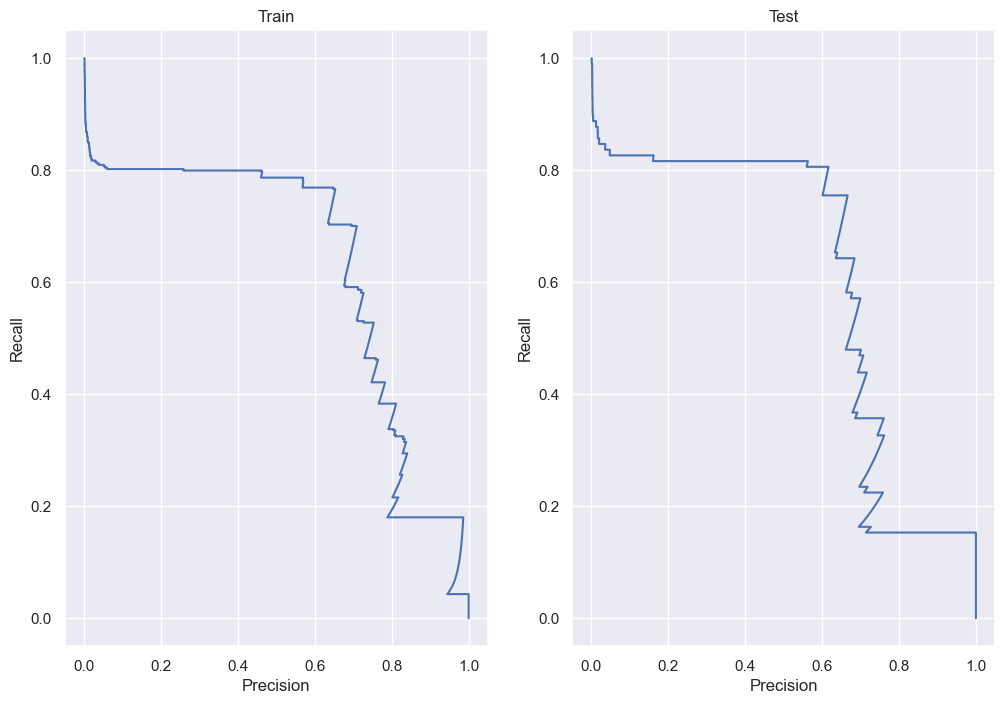

In [105]:
print_metrics(target_train, target_test, train_scores, test_scores)

Результат даже близко не дотягивает до линейной модели

## Isolation Forest

In [74]:
isol_for = IsolationForest(
    n_jobs=-1,
    contamination=.01,
    n_estimators=500,
    random_state=random_state
)

isol_for.fit(data_train);

In [75]:
train_scores = -isol_for.score_samples(data_train)
test_scores = -isol_for.score_samples(data_test)

Optimal threshold is - 0.7335189020525337

f1 score train - 0.024752475247524754
f1 score test - 0.0
rocauc score train - 0.9504993846278756
rocauc score test - 0.9580012963260713
precision train - 0.5
precision test - 0.0
recall train - 0.012690355329949238
recall test - 0.0


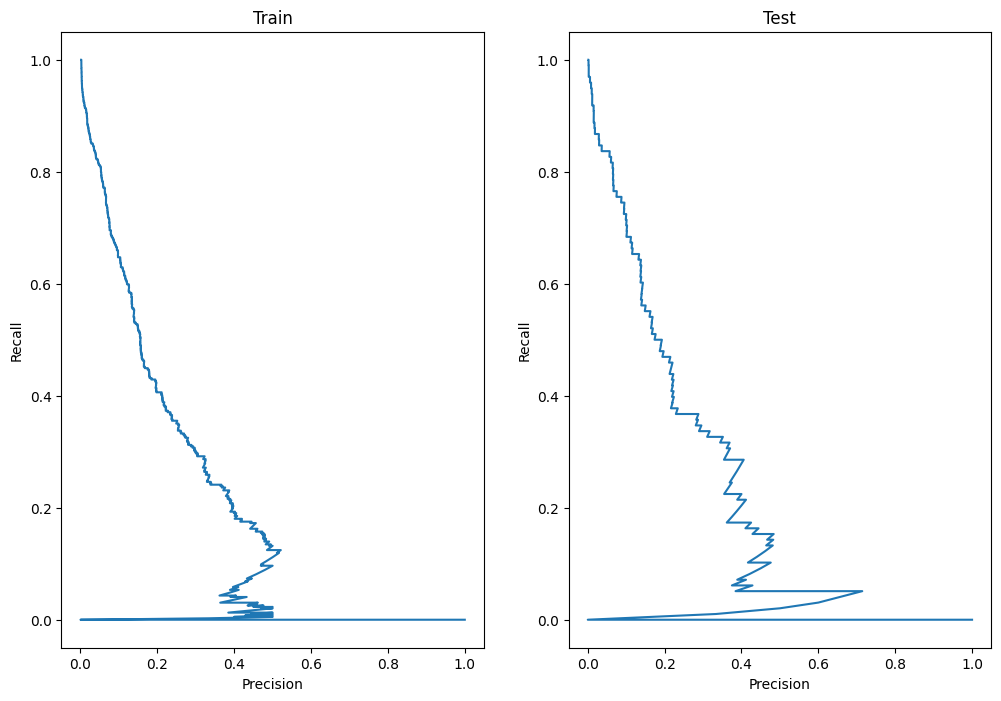

In [76]:
print_metrics(target_train, target_test, train_scores, test_scores)

Также, результат очень плохой

## One-class SVM

In [2]:
svm = OneClassSVM(kernel='linear')

%time svm.fit(data_train);

CPU times: total: 0 ns
Wall time: 0 ns


NameError: name 'OneClassSVM' is not defined

In [ ]:
train_pred = svm.predict(data_train)
test_pred = svm.predict(data_test)

train_scores = -svm.score_samples(data_train)
test_scores = -svm.score_samples(data_test)

In [ ]:
train_pred = np.clip(train_pred, 0, 1)
train_pred = np.where((train_pred == 0) | (train_pred == 1), train_pred^1, train_pred)

test_pred = np.clip(test_pred, 0, 1)
test_pred = np.where((test_pred == 0) | (test_pred == 1), test_pred^1, test_pred)

In [ ]:
print(f'f1 score train - {f1_score(target_train, train_pred)}')
print(f'f1 score test - {f1_score(target_test, test_pred)}')

print(f'rocauc train - {roc_auc_score(target_train, train_scores)}')
print(f'rocauc test - {roc_auc_score(target_test, test_pred)}')

f1 score train - 0.18930041152263372
f1 score test - 0.19402985074626866


## DBSCAN

In [52]:
dbscan = DBSCAN(eps=.99, min_samples=2, n_jobs=-1)

train_pred = dbscan.fit_predict(data_train);

In [53]:
train_pred

array([-1,  0, -1, ..., 37, -1, -1], dtype=int64)

In [54]:
np.unique(train_pred, return_counts=True)

(array([  -1,    0,    1, ..., 9836, 9837, 9838], dtype=int64),
 array([106062,   1697,      4, ...,      2,      2,      2], dtype=int64))

Методы кластеризации очень плохо справляются, помечая более 50 процентов данных как шум.

## Random Forest

In [55]:
ran_for = RandomForestClassifier(n_jobs=-1, random_state=random_state)

params = {
    'max_depth': [None, 5, 7, 10]
}

skf.get_n_splits(data_train, target_train)

gs = GridSearchCV(ran_for, params, scoring='f1', cv=skf, n_jobs=-1, verbose=5)

%time gs.fit(data_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [56]:
gs.best_params_, gs.best_score_

({'max_depth': None}, 0.8701841190074735)

In [58]:
ran_for = RandomForestClassifier(
    n_jobs=-1,
    n_estimators=500,
    **gs.best_params_,
    random_state=random_state
)
ran_for.fit(data_train, target_train)

print_metrics(ran_for, data_train, target_train, data_test, target_test)

f1 score train - 1.0
f1 score test - 0.7283950617283952
rocauc score train - 1.0
rocauc score test - 0.9214882017100595


Bagging показал довольно неплохой результат, но, всё равно, не смог побить линейную модель

## Gradient Boosting

In [62]:
xgb = XGBClassifier(random_state=random_state)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

skf.get_n_splits(data_train, target_train)

gs = RandomizedSearchCV(xgb,
        params,
        scoring='f1',
        n_iter=10,
        cv=skf,
        n_jobs=-1,
        verbose=3,
        random_state=random_state
)

%time gs.fit(data_train, target_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [63]:
gs.best_params_, gs.best_score_

({'subsample': 0.8,
  'min_child_weight': 10,
  'max_depth': 3,
  'gamma': 5,
  'colsample_bytree': 1.0},
 0.8727520219494093)

In [66]:
xgb = XGBClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=.03,
    **gs.best_params_,
    random_state=random_state
)
xgb.fit(data_train, target_train)

print_metrics(xgb, data_train, target_train, data_test, target_test)

f1 score train - 0.908108108108108
f1 score test - 0.7393939393939395
rocauc score train - 0.9986418785084675
rocauc score test - 0.9701118242738852


Бустинг выглядит более многообещающе